### Imports

In [3]:
#!pip install gensim
#!pip install pyLDAvis

In [4]:
import json
import pandas as pd
import re
import string
import unidecode
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

In [5]:
import random

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

In [6]:
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Importar utils:

In [7]:
import os 
path = os.path.dirname(os.path.realpath('AmparoAlias_topic_modelling')) 
print(path)
import sys 
sys.path.insert (0, path) 

/Users/amparoalias/Desktop/Keepcoding/nlp


In [8]:
import utils 
from utils import do_text_transformations

### Read data

Estos json se han obtenido de reviews de Amazon:http://jmcauley.ucsd.edu/data/amazon/ en files -> "Small" subsets for experimentation
<br> 
- Cell Phones and Accessories
- Pet Supplies
- Musical Instruments
<br>*Nota:* los archivos que continen los datos pesan demasiado como para subirlos mediante git.

In [9]:
filename = "data/cellphones_accessories.json"
cellphones_data = []
for line in open(filename, 'r'):
    cellphones_data.append(json.loads(line))
cellphones_data = json.dumps(cellphones_data)
cellphones_data = pd.read_json(cellphones_data)
cellphones_data = cellphones_data[['reviewText']]

In [10]:
filename = "data/musical_instruments.json"
musical_data = []
for line in open(filename, 'r'):
    musical_data.append(json.loads(line))
musical_data = json.dumps(musical_data)
musical_data = pd.read_json(musical_data)
musical_data = musical_data[['reviewText']]

In [11]:
filename = "data/pet_supplies.json"
pet_data = []
for line in open(filename, 'r'):
    pet_data.append(json.loads(line))
pet_data = json.dumps(pet_data)
pet_data = pd.read_json(pet_data)
pet_data = pet_data[['reviewText']]

##### Sample to have less amount of data

In [12]:
n = 500
cellphones_data = cellphones_data.sample(n=n, random_state=1)
musical_data = musical_data.sample(n=n, random_state=1)
pet_data = pet_data.sample(n=n, random_state=1)

In [13]:
data = cellphones_data.append(musical_data)
data = data.append(pet_data)

In [14]:
data.shape

(1500, 1)

### Preprocesado 
*(Mismo que en el ejercicio de sentiment_analysis, donde está más detallado)*

In [15]:
data = do_text_transformations(data = data, text_field = 'reviewText')

In [16]:
data.head(1).values

array([['Loved this item initially but as most white items go...it started to turn brown after a couple of weeks. Nothing....I mean nothing could get it clean. Would not recommend it.',
        'loved this item initially but as most white items go it started to turn brown after a couple of weeks nothing i mean nothing could get it clean would not recommend it',
        'love item initi white item go start turn brown coupl week noth mean noth could get clean would recommend']],
      dtype=object)

In [17]:
processed_texts = []
for text in data['Standardized_Text']:
    processed_texts.append(text.split())

In [18]:
processed_texts[:10]

[['love',
  'item',
  'initi',
  'white',
  'item',
  'go',
  'start',
  'turn',
  'brown',
  'coupl',
  'week',
  'noth',
  'mean',
  'noth',
  'could',
  'get',
  'clean',
  'would',
  'recommend'],
 ['reason',
  'cover',
  'loos',
  'star',
  'doesnt',
  'fit',
  'charger',
  'bough',
  'pre',
  'own',
  'new',
  'cover',
  'sinjimoru',
  'aluminum',
  'sync',
  'charg',
  'dock',
  'stand',
  'samsung',
  'galaxi',
  'cover',
  'thick',
  'stand',
  'come',
  'cord',
  'sinc',
  'fit',
  'certain',
  'way',
  'im',
  'bit',
  'disappoint'],
 ['got',
  'work',
  'connector',
  'side',
  'bottom',
  'placement',
  'awkward',
  'samsung',
  'like',
  'fine'],
 ['tri',
  'work',
  'pretti',
  'well',
  'pleas',
  'work',
  'work',
  'work',
  'happi',
  'great',
  'bye'],
 ['phone',
  'case',
  'look',
  'nice',
  'last',
  'quit',
  'rhineston',
  'start',
  'peel',
  'still',
  'worth',
  'money',
  'though'],
 ['kept',
  'factori',
  'screen',
  'cover',
  'phone',
  'abl',
  'get',

##### Diccionario id-palabra

In [19]:
dictionary = Dictionary(processed_texts)

In [20]:
len(dictionary)

5820

##### Matriz doc-palabra

In [21]:
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]

### Vemos cual es el número óptimo de topics para entrenar después el algoritmo

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [46]:
start_ = 1
end_ = 5
step_ = 1

In [59]:
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_texts,
    start=start_,
    limit=end_,
    step=step_
)

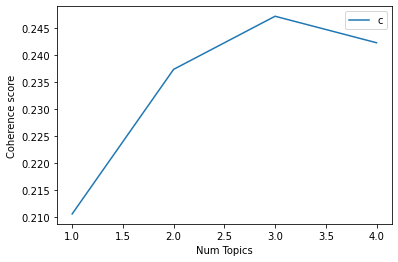

In [60]:
x = range(start_, end_, step_)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [61]:
optimal_num_topics = 3

Vemos que lo que nos dice este indicador sobre el número óptimo de topics a utilizar concuerda exactamente con lo esperado, ya que como input tenemos una combinación de 3 datasets de temática distinta

### Entrenamos el modelo LDA

In [66]:
num_topics = optimal_num_topics

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto'
)

In [69]:
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03
0,use,one,case
1,like,dog,phone
2,one,use,use
3,good,like,one
4,phone,well,get
5,work,love,like
6,product,get,work
7,great,string,screen
8,get,would,batteri
9,sound,cat,guitar


In [68]:
# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.485086499274693

Coherence Score:  0.24411763374384243


In [70]:
# Visualizar los topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.048547 -0.020913       1        1  35.246985
1      0.054846 -0.014449       2        1  34.253990
0     -0.006300  0.035362       3        1  30.499025, topic_info=        Term        Freq       Total Category  logprob  loglift
61      case  496.000000  496.000000  Default  30.0000  30.0000
1115     dog  385.000000  385.000000  Default  29.0000  29.0000
67     phone  477.000000  477.000000  Default  28.0000  28.0000
110   screen  191.000000  191.000000  Default  27.0000  27.0000
21     charg  188.000000  188.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
401     make   75.542030  270.328831   Topic3  -5.5753  -0.0875
130     also   72.856459  245.333911   Topic3  -5.6115  -0.0267
810     even   64.303494  184.434916   Topic3  -5.7364   0.1338
279    price   66.253134  219.600240   Topic3  -5.7065  -0.0109
169     much   65.991920  256.711075   Topic3  -5.7105  -0.1709

[275 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4724      1  0.049223  allergi
4724      2  0.836797  allergi
4724      3  0.147670  allergi
130       1  0.464673     also
130       2  0.236412     also
...     ...       ...      ...
53        2  0.308871     work
53        3  0.324886     work
16        1  0.297366    would
16        2  0.388088    would
16        3  0.315007    would

[551 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [ ]:
pyLDAvis.save_html(vis, '../topics_vis_0.html')

- Aparentemente podemos intuir que los tres topics están bastante diferenciados y que contienen la misma cantidad de palabras aproximadamente. 
<br> 
- Con respecto al topic 1: parece es el que más podríamos asociar a las reviews que nos hablan de "teléfonos y sus accesorios"  ya que entre las palabras que más representan al topic tenemos: case, phone, screen, batteri, charge, protector... Aunque encontramos palabras que no corresponden como "guitar".
- Con respecto al topic 2: lo podemos asociar a las reviews de pet_supplies. Cuadra bastante ya que las palabras que más representan el topic son: dog, cat, love, time, play...
- Finalmente, el topic 3 lo podemos relacionar con las reviews de "instrumentos musicales" ya que entre las palabras más destacadas de este topic tenemos: good, sound, microphone, headset.. Y entre las más frecuentes (en el dataframe de arriba) tenemos también "guitar".